In [1]:
# %matplotlib inline
# %load_ext autotime
# %config InlineBackend.figure_format = 'retina'

time: 6.44 ms


In [2]:
import matplotlib as mpl
import matplotlib.pyplot as pt
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats
import sklearn as sk
import sklearn.model_selection
import sklearn.preprocessing

time: 771 ms


In [3]:
import keras
import tensorflow as tf

Using TensorFlow backend.
/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


time: 1.56 s


In [4]:
mpl.rcParams[ 'figure.figsize' ] = ( 18, 3 )
pd.set_option( 'display.max_columns', 200 )

time: 1.75 ms


In [5]:
with open( 'data/Humanoid-v1-data.csv', 'rb' ) as f:
    d = pickle.load( f )

time: 11 s


In [6]:
x = d[ 'observations' ]
y = np.squeeze( d[ 'actions' ], 1 )
x.shape, y.shape

((199081, 376), (199081, 17))

time: 22.6 ms


In [7]:
np.min( x ), np.max( x ), np.min( y ), np.max( y )

(-1758.197300316953, 4748.7526819906043, -4.3187308, 5.5876684)

time: 280 ms


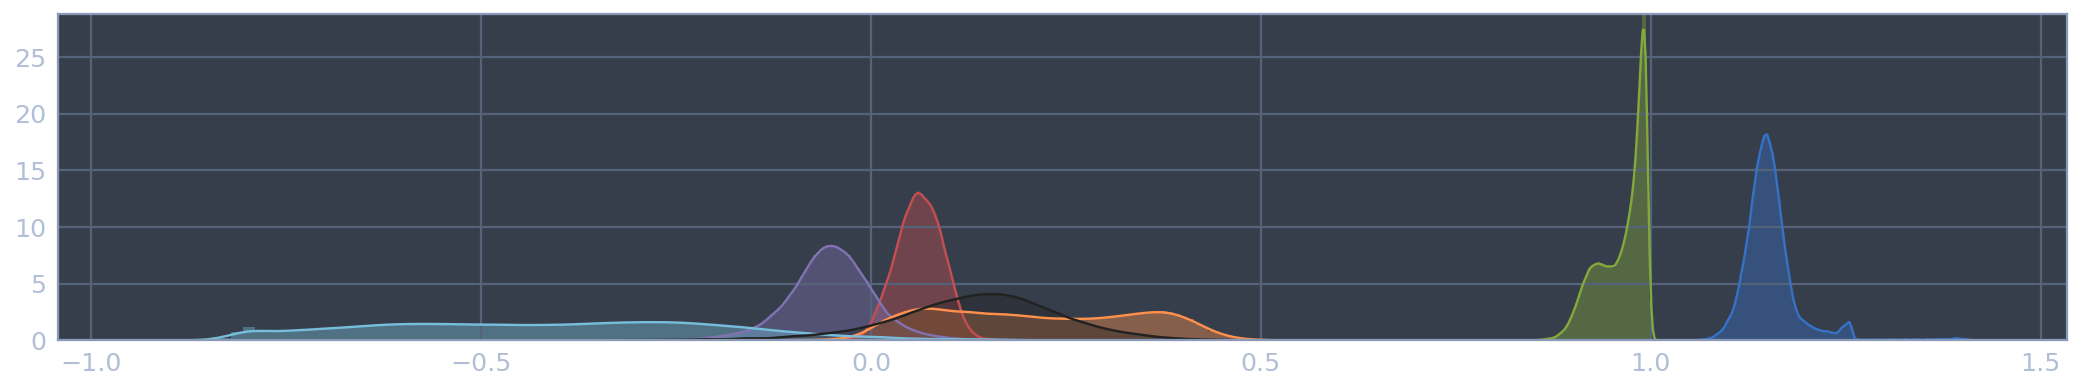

time: 2.25 s


In [8]:
for i in range( 7 ):
    sns.distplot( x[ :, i ], bins=100 )

In [9]:
x_dim = x.shape[ 1 ]
y_dim = y.shape[ 1 ]

time: 1.33 ms


In [10]:
train_x, val_x, train_y, val_y = sk.model_selection.train_test_split( x, y )
( train_x.shape, train_y.shape ), ( val_x.shape, val_y.shape )

(((149310, 376), (149310, 17)), ((49771, 376), (49771, 17)))

time: 434 ms


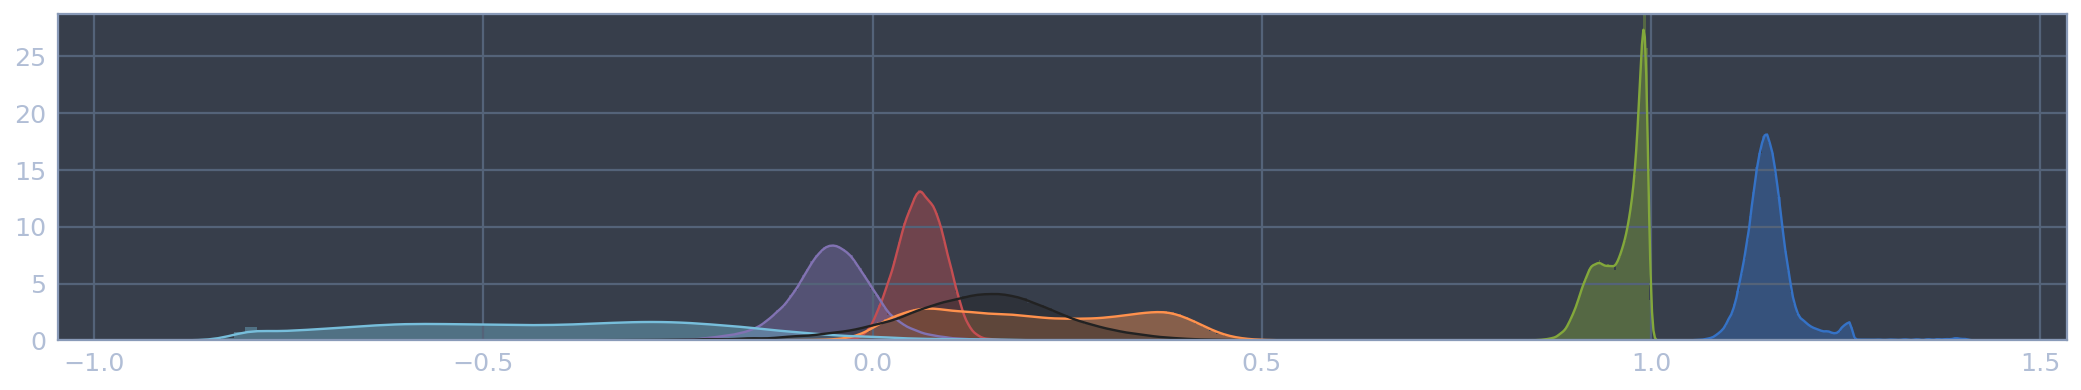

time: 2.51 s


In [11]:
for i in range( 7 ):
    sns.distplot( train_x[ :, i ], bins=100 )

# multiple models each for a single dimension (without standardization)

In [12]:
m_in = keras.layers.Input( shape=( x_dim, ) )
m_out = keras.layers.Dense( 1024, kernel_initializer='glorot_normal' )( m_in )
m_out = keras.layers.BatchNormalization()( m_out )
m_out = keras.layers.Activation( 'tanh' )( m_out )
m_out = keras.layers.Dense( 1, activation='linear' )( m_out )
m = keras.models.Model( inputs=m_in, outputs=m_out )
m.compile( optimizer='adam', loss='mse' )
m.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 376)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              386048    
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
activation_1 (Activation)    (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1025      
Total params: 391,169
Trainable params: 389,121
Non-trainable params: 2,048
_________________________________________________________________
time: 199 ms


In [13]:
cbs = [ keras.callbacks.EarlyStopping( min_delta=0, patience=10 ) ]
h = m.fit( train_x, train_y[ :, 0 ], batch_size=1024, epochs=100, verbose=0, callbacks=cbs, validation_data=( val_x, val_y[ :, 0 ] ) )
p = m.predict( train_x, batch_size=1024 )

time: 15min 43s


0.010178883569 0.00946688792406


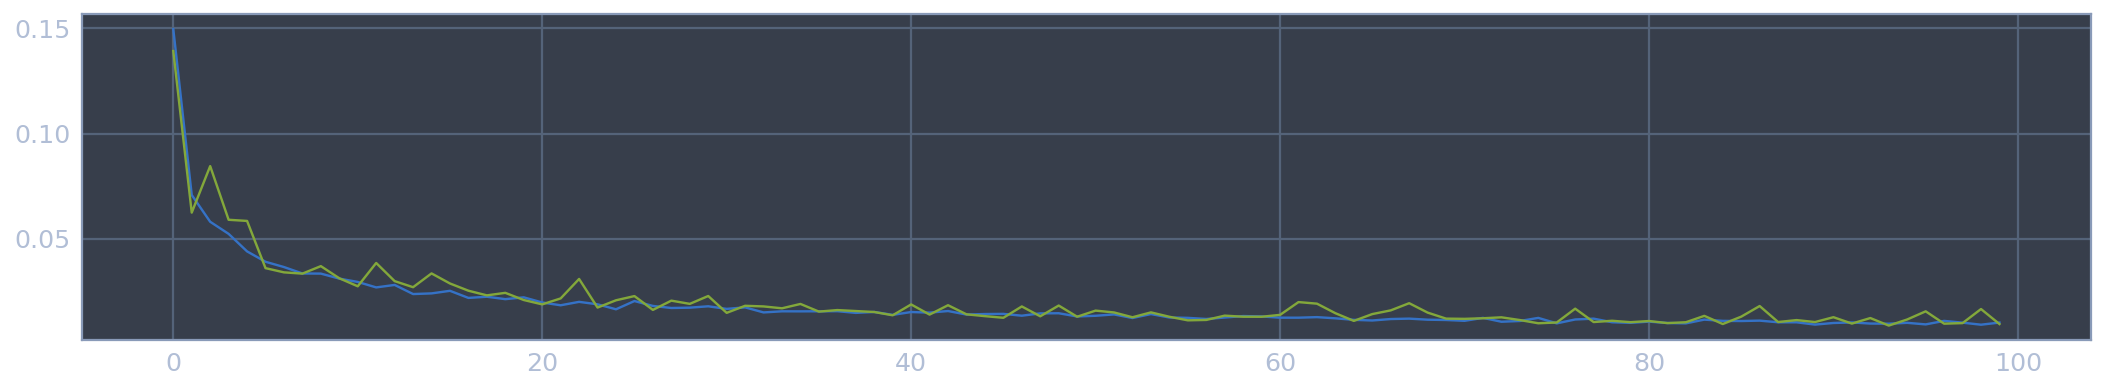

time: 456 ms


In [19]:
print( h.history[ 'loss' ][ -1 ], h.history[ 'val_loss' ][ -1 ] )
pd.Series( h.history[ 'loss' ] ).plot();
pd.Series( h.history[ 'val_loss' ] ).plot();

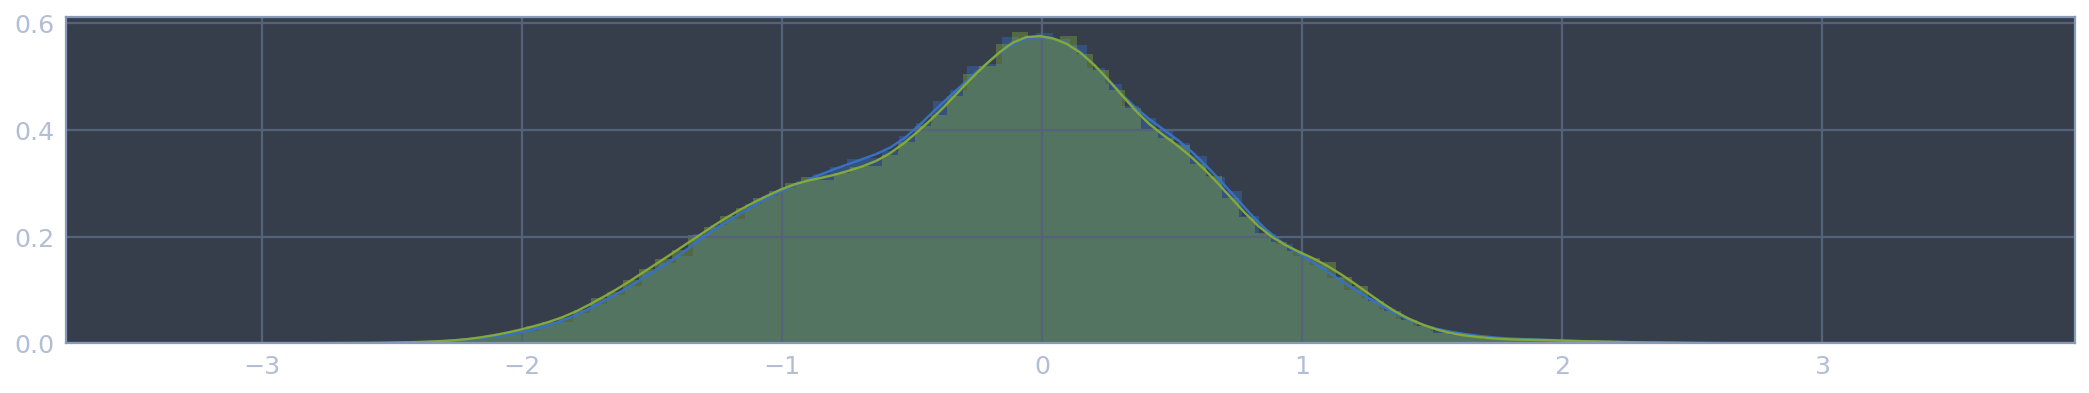

time: 816 ms


In [15]:
sns.distplot( train_y[ :, 0 ], bins=100 );
sns.distplot( p, bins=100 );

In [16]:
scipy.stats.ks_2samp( y[ :, 0 ], p.reshape( -1 ) )

Ks_2sampResult(statistic=0.0091647166886690001, pvalue=1.1786986075093965e-06)

time: 493 ms


In [17]:
train_y[ :, 0 ][ : 20 ]

array([ 0.64672816,  0.7433449 , -1.10643625,  0.27920938, -0.09074471,
        0.25438169, -1.20819402,  0.06700885, -1.12508607, -0.84215951,
       -0.03200199,  1.12431157,  0.80128694,  0.57689595,  0.36978731,
       -0.86058581, -0.34694865,  0.08957912, -0.05426034,  0.34421769], dtype=float32)

time: 5.05 ms


In [18]:
m.predict( train_x[ : 20, : ] )[ :, 0 ]

array([ 0.5909043 ,  0.77350038, -1.08847904,  0.28284934,  0.10299154,
        0.20744814, -1.22929132, -0.06143288, -1.07430637, -0.85229617,
       -0.00264398,  0.94849658,  0.74621075,  0.65245992,  0.34330249,
       -0.9392221 , -0.38823712,  0.02629619, -0.08727331,  0.202015  ], dtype=float32)

time: 11.8 ms


# multiple models each for a single dimension (with standardization)

In [20]:
scaler = sk.preprocessing.StandardScaler()

time: 12.2 ms


In [21]:
scaler.fit( train_x )
train_x2 = scaler.transform( train_x )
val_x2 = scaler.transform( val_x )

time: 48.3 s


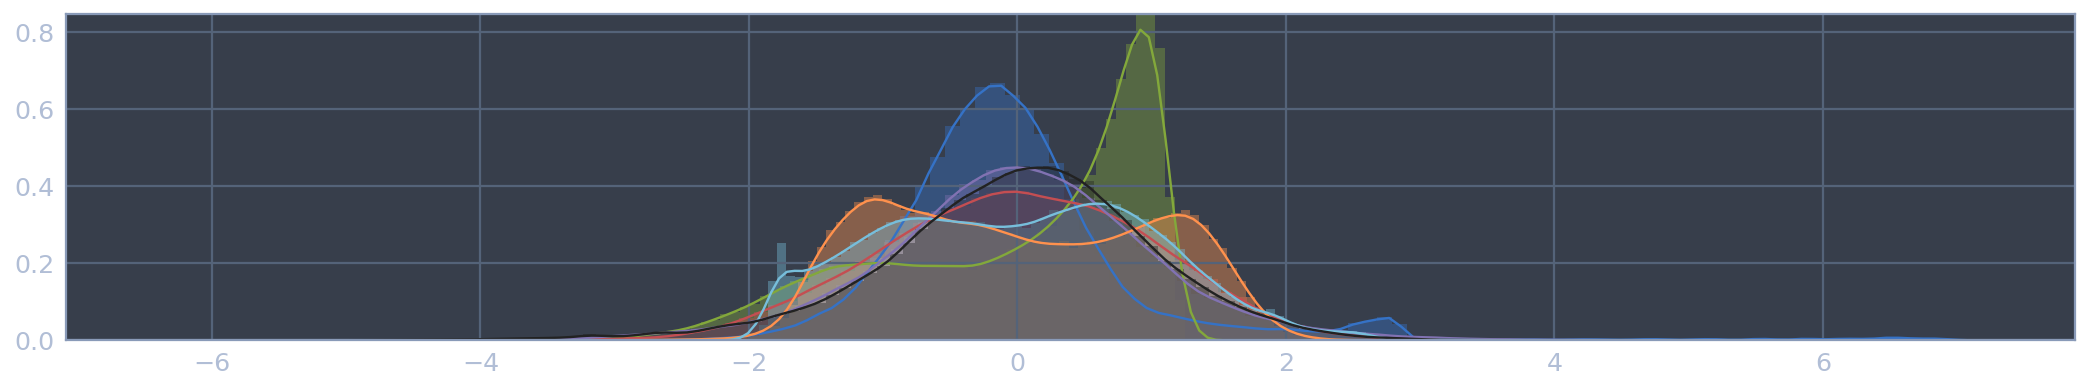

time: 4.79 s


In [22]:
for i in range( 7 ):
    sns.distplot( train_x2[ :, i ], bins=100 )

In [23]:
m_in = keras.layers.Input( shape=( x_dim, ) )
m_out = keras.layers.Dense( 1024, kernel_initializer='glorot_normal' )( m_in )
m_out = keras.layers.BatchNormalization()( m_out )
m_out = keras.layers.Activation( 'tanh' )( m_out )
m_out = keras.layers.Dense( 1, activation='linear' )( m_out )
m = keras.models.Model( inputs=m_in, outputs=m_out )
m.compile( optimizer='adam', loss='mse' )
m.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 376)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              386048    
_________________________________________________________________
batch_normalization_2 (Batch (None, 1024)              4096      
_________________________________________________________________
activation_2 (Activation)    (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 1025      
Total params: 391,169
Trainable params: 389,121
Non-trainable params: 2,048
_________________________________________________________________
time: 219 ms


In [24]:
cbs = [ keras.callbacks.EarlyStopping( min_delta=0, patience=10 ) ]
h = m.fit( train_x2, train_y[ :, 0 ], batch_size=1024, epochs=100, verbose=0, callbacks=cbs, validation_data=( val_x2, val_y[ :, 0 ] ) )
p = m.predict( train_x2, batch_size=1024 )

time: 14min 36s


0.00469369492735 0.00485349152969


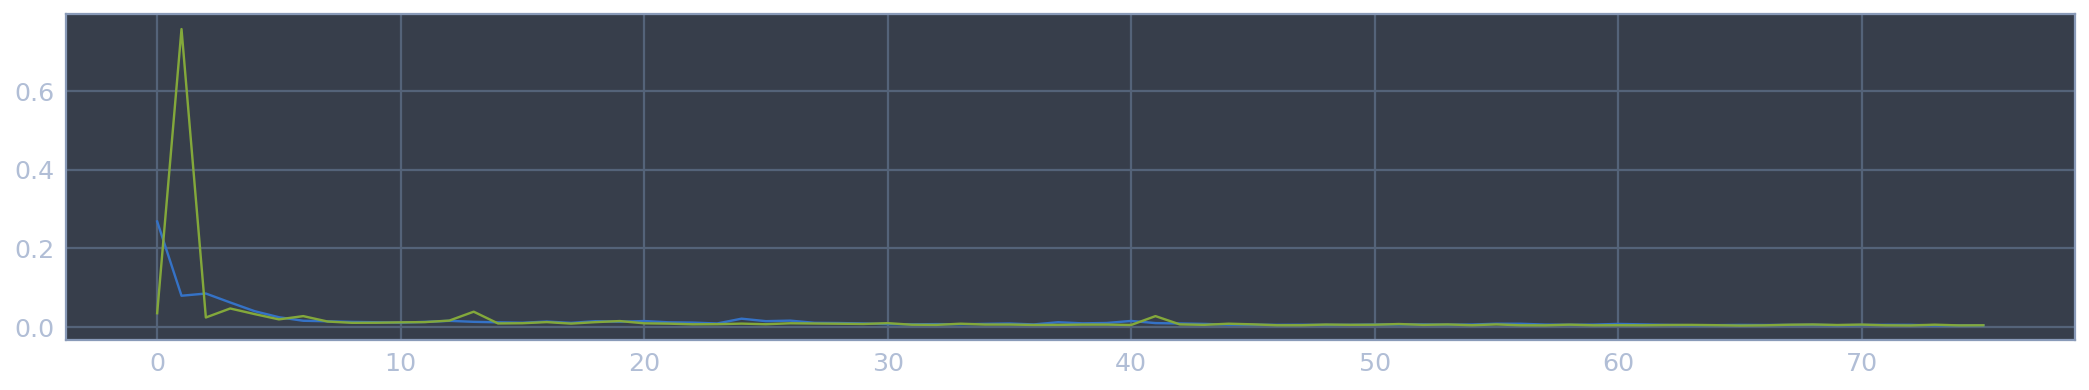

time: 543 ms


In [25]:
print( h.history[ 'loss' ][ -1 ], h.history[ 'val_loss' ][ -1 ] )
pd.Series( h.history[ 'loss' ] ).plot();
pd.Series( h.history[ 'val_loss' ] ).plot();

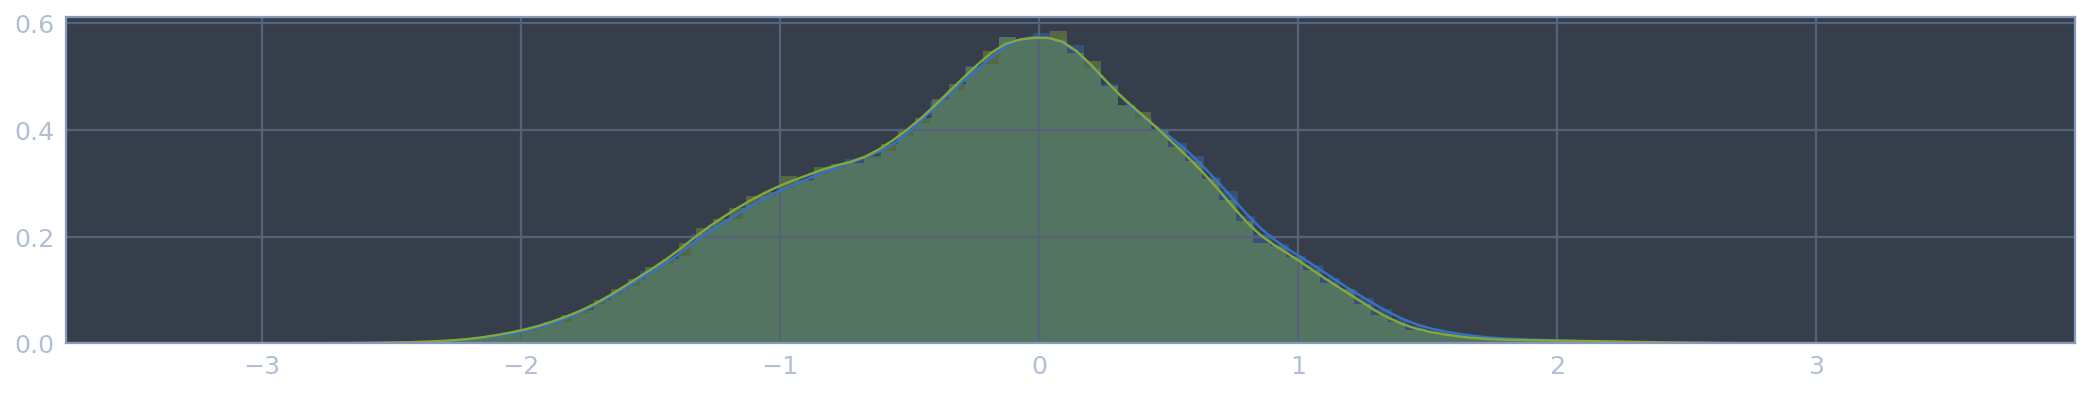

time: 1.16 s


In [26]:
sns.distplot( train_y[ :, 0 ], bins=100 );
sns.distplot( p, bins=100 );

In [27]:
scipy.stats.ks_2samp( train_y[ :, 0 ], p.reshape( -1 ) )

Ks_2sampResult(statistic=0.013267698077824686, pvalue=7.5209250861740488e-12)

time: 125 ms


# single fully connected model for all dimensions (without standardization)

In [28]:
m_in = keras.layers.Input( shape=( x_dim, ) )
m_out = keras.layers.Dense( 1024 * y_dim, kernel_initializer='glorot_normal' )( m_in )
m_out = keras.layers.BatchNormalization()( m_out )
m_out = keras.layers.Activation( 'tanh' )( m_out )
m_out = keras.layers.Dense( y_dim, activation='linear' )( m_out )
m = keras.models.Model( inputs=m_in, outputs=m_out )
m.compile( optimizer='adam', loss='mse' )
m.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 376)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 17408)             6562816   
_________________________________________________________________
batch_normalization_3 (Batch (None, 17408)             69632     
_________________________________________________________________
activation_3 (Activation)    (None, 17408)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 17)                295953    
Total params: 6,928,401
Trainable params: 6,893,585
Non-trainable params: 34,816
_________________________________________________________________
time: 92.1 ms


In [29]:
cbs = [ keras.callbacks.EarlyStopping( min_delta=0, patience=10 ) ]
h = m.fit( train_x, train_y, batch_size=1024, epochs=100, verbose=0, callbacks=cbs, validation_data=( val_x, val_y ) )
p = m.predict( train_x, batch_size=1024 )

time: 2h 18min 47s


0.0411907015417 0.03687854952


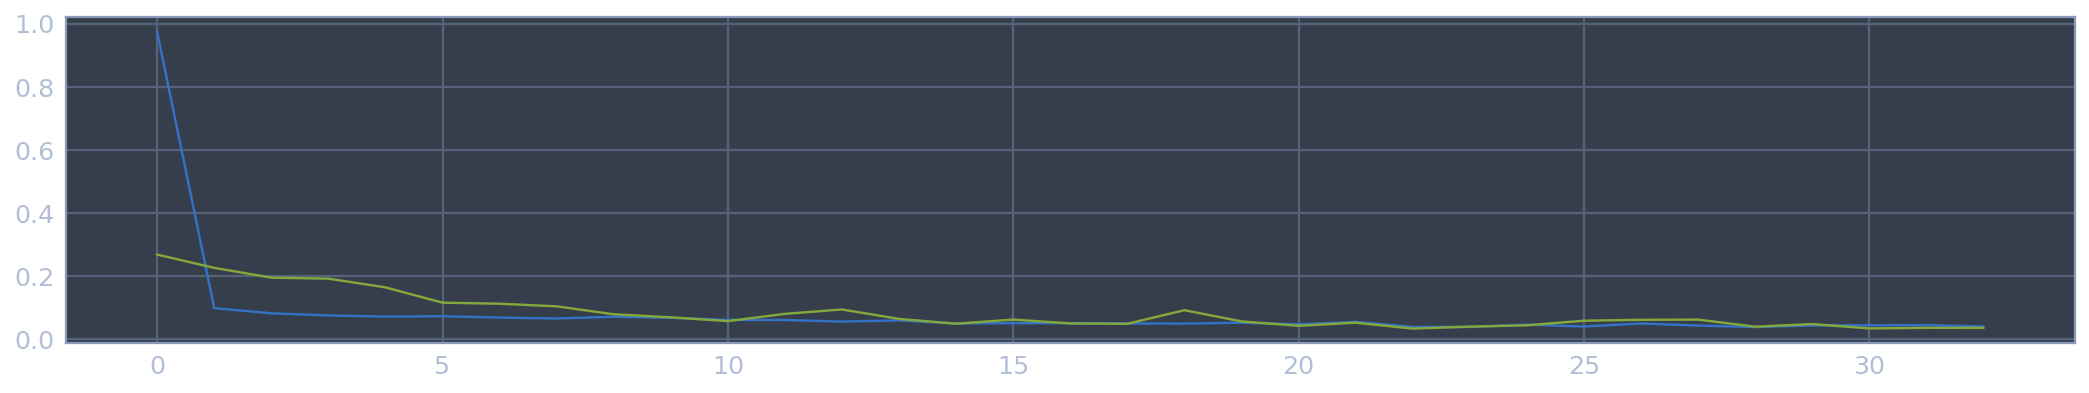

time: 1.16 s


In [30]:
print( h.history[ 'loss' ][ -1 ], h.history[ 'val_loss' ][ -1 ] )
pd.Series( h.history[ 'loss' ] ).plot();
pd.Series( h.history[ 'val_loss' ] ).plot();

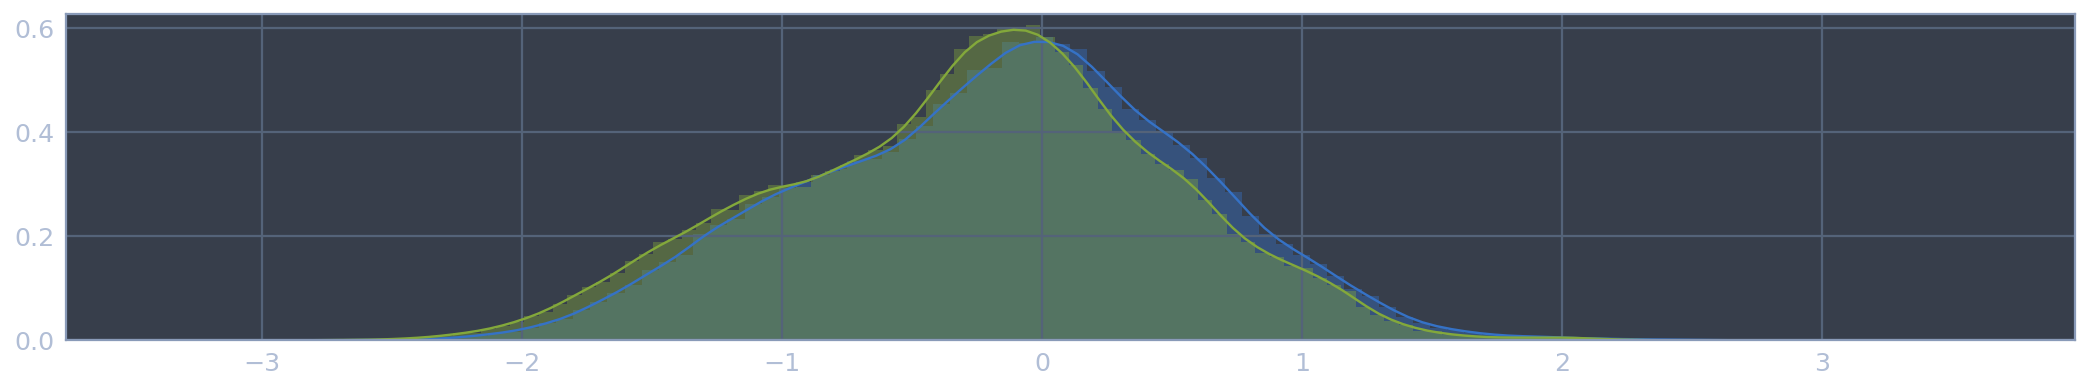

time: 1.06 s


In [31]:
sns.distplot( train_y[ :, 0 ], bins=100 );
sns.distplot( p[ :, 0 ], bins=100 );

In [32]:
[ scipy.stats.ks_2samp( y[ :, i ], p[ :, i ] ) for i in range( y_dim ) ]

[Ks_2sampResult(statistic=0.062650992421286911, pvalue=1.4989097462138169e-291),
 Ks_2sampResult(statistic=0.038257555674472532, pvalue=5.5448001677172128e-109),
 Ks_2sampResult(statistic=0.035361147220120293, pvalue=3.6223114503741713e-93),
 Ks_2sampResult(statistic=0.018307834599778361, pvalue=2.7619304116305777e-25),
 Ks_2sampResult(statistic=0.020241261762355023, pvalue=8.1891487925129691e-31),
 Ks_2sampResult(statistic=0.039676680766984385, pvalue=3.4744148156215458e-117),
 Ks_2sampResult(statistic=0.033475592566717505, pvalue=1.5339730283385206e-83),
 Ks_2sampResult(statistic=0.035905354234042897, pvalue=4.8131020380303551e-96),
 Ks_2sampResult(statistic=0.027298282503825377, pvalue=1.0724424067123054e-55),
 Ks_2sampResult(statistic=0.018584648721272079, pvalue=4.828024626844896e-26),
 Ks_2sampResult(statistic=0.083864741751357386, pvalue=0.0),
 Ks_2sampResult(statistic=0.051725817664819984, pvalue=7.1894755595348022e-199),
 Ks_2sampResult(statistic=0.026200045864689714, pvalue=2

time: 1.19 s


In [33]:
t = [ scipy.stats.ks_2samp( y[ :, i ], p[ :, i ] ).statistic for i in range( y_dim ) ]
np.mean( t ), np.var( t )

(0.03511343622594508, 0.00028835425442605032)

time: 932 ms


# singel fully connected model for all dimensions (with standardization)

In [34]:
m_in = keras.layers.Input( shape=( x_dim, ) )
m_out = keras.layers.Dense( 1024 * y_dim, kernel_initializer='glorot_normal' )( m_in )
m_out = keras.layers.BatchNormalization()( m_out )
m_out = keras.layers.Activation( 'tanh' )( m_out )
m_out = keras.layers.Dense( y_dim, activation='linear' )( m_out )
m = keras.models.Model( inputs=m_in, outputs=m_out )
m.compile( optimizer='adam', loss='mse' )
m.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 376)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 17408)             6562816   
_________________________________________________________________
batch_normalization_4 (Batch (None, 17408)             69632     
_________________________________________________________________
activation_4 (Activation)    (None, 17408)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 17)                295953    
Total params: 6,928,401
Trainable params: 6,893,585
Non-trainable params: 34,816
_________________________________________________________________
time: 282 ms


In [35]:
cbs = [ keras.callbacks.EarlyStopping( min_delta=0, patience=10 ) ]
h = m.fit( train_x2, train_y, batch_size=1024, epochs=100, verbose=0, callbacks=cbs, validation_data=( val_x2, val_y ) )
p = m.predict( train_x2, batch_size=1024 )

time: 1h 48min 45s


0.0349884455477 0.038488841134


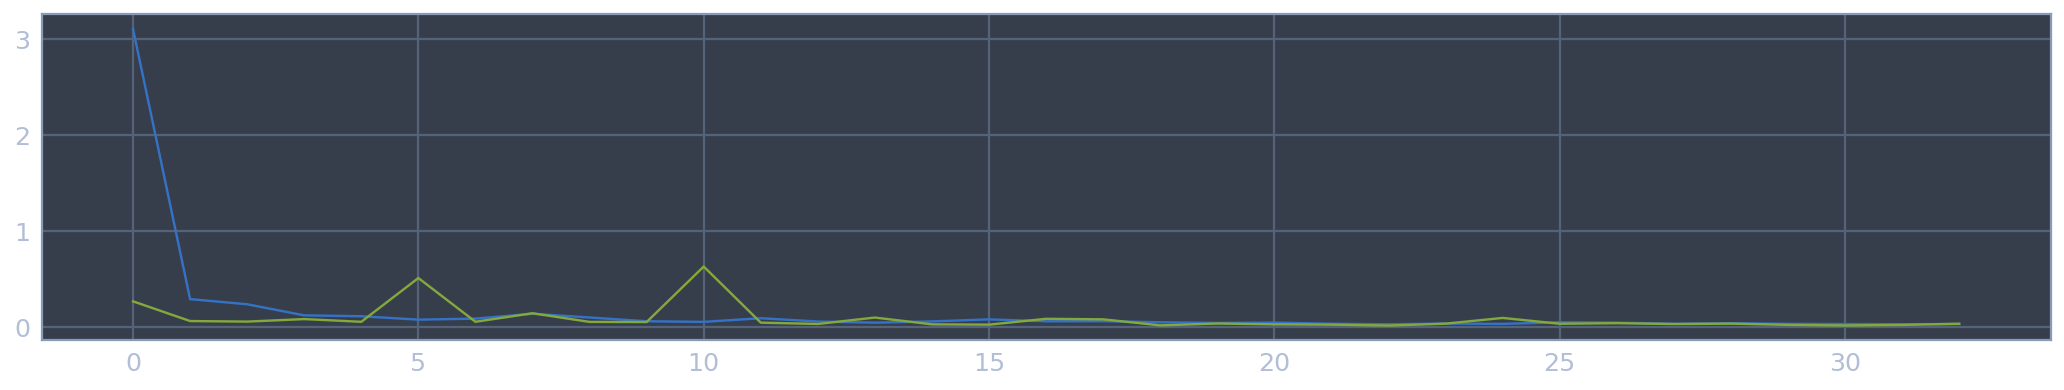

time: 1.3 s


In [36]:
print( h.history[ 'loss' ][ -1 ], h.history[ 'val_loss' ][ -1 ] )
pd.Series( h.history[ 'loss' ] ).plot();
pd.Series( h.history[ 'val_loss' ] ).plot();

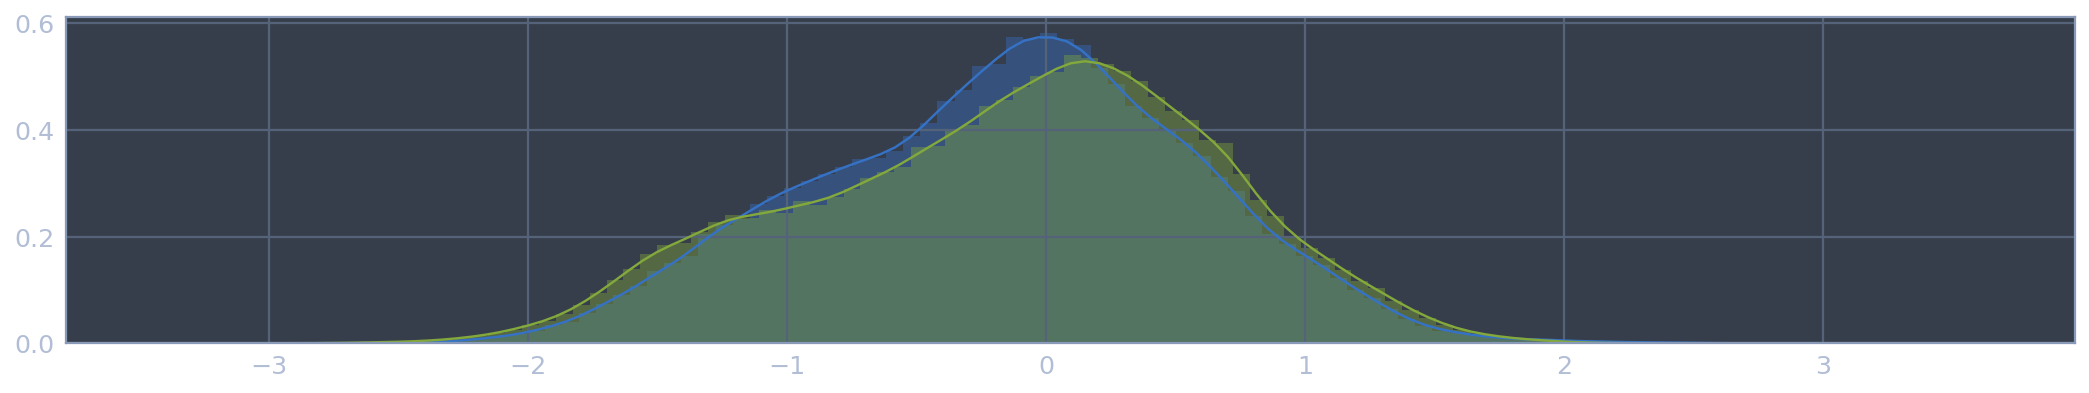

time: 1.2 s


In [37]:
sns.distplot( train_y[ :, 0 ], bins=100 );
sns.distplot( p[ :, 0 ], bins=100 );

In [38]:
[ scipy.stats.ks_2samp( y[ :, i ], p[ :, i ] ) for i in range( y_dim ) ]

[Ks_2sampResult(statistic=0.045445751094472797, pvalue=1.3123204171285746e-153),
 Ks_2sampResult(statistic=0.053632369106548894, pvalue=9.083590094738499e-214),
 Ks_2sampResult(statistic=0.023869340492915669, pvalue=1.1051765075397279e-42),
 Ks_2sampResult(statistic=0.0085531581342744856, pvalue=7.500067347502879e-06),
 Ks_2sampResult(statistic=0.023801563448933, pvalue=1.9189869227528667e-42),
 Ks_2sampResult(statistic=0.016354251260531694, pvalue=2.9080692875547713e-20),
 Ks_2sampResult(statistic=0.036512248027896599, pvalue=2.6466787149771305e-99),
 Ks_2sampResult(statistic=0.022801773243896539, pvalue=5.4812808017938597e-39),
 Ks_2sampResult(statistic=0.013598123253114491, pvalue=3.8589464602386429e-14),
 Ks_2sampResult(statistic=0.043421763846075587, pvalue=2.8748949034826677e-140),
 Ks_2sampResult(statistic=0.045233084150396563, pvalue=3.5346707327198304e-152),
 Ks_2sampResult(statistic=0.037677338272853134, pvalue=1.0272845169240845e-105),
 Ks_2sampResult(statistic=0.03520607406

time: 1.35 s


In [39]:
t = [ scipy.stats.ks_2samp( y[ :, i ], p[ :, i ] ).statistic for i in range( y_dim ) ]
np.mean( t ), np.var( t )

(0.037397258736063324, 0.00033874586038581587)

time: 897 ms


# multiple models each for a single dimension (with standardization)

In [40]:
m_in = keras.layers.Input( shape=( x_dim, ) )
m_out = keras.layers.Dense( 64, kernel_initializer='glorot_normal' )( m_in )
m_out = keras.layers.BatchNormalization()( m_out )
m_out = keras.layers.Activation( 'tanh' )( m_out )
m_out = keras.layers.Dense( 1, activation='linear' )( m_out )
m = keras.models.Model( inputs=m_in, outputs=m_out )
m.compile( optimizer='adam', loss='mse' )
m.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 376)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                24128     
_________________________________________________________________
batch_normalization_5 (Batch (None, 64)                256       
_________________________________________________________________
activation_5 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 65        
Total params: 24,449
Trainable params: 24,321
Non-trainable params: 128
_________________________________________________________________
time: 158 ms


In [41]:
cbs = [ keras.callbacks.EarlyStopping( min_delta=0, patience=10 ) ]
h = m.fit( train_x2, train_y[ :, 0 ], batch_size=1024, epochs=100, verbose=0, callbacks=cbs, validation_data=( val_x2, val_y[ :, 0 ] ) )
p = m.predict( train_x2, batch_size=1024 )

time: 2min 30s


0.0043162145334 0.00432718056934


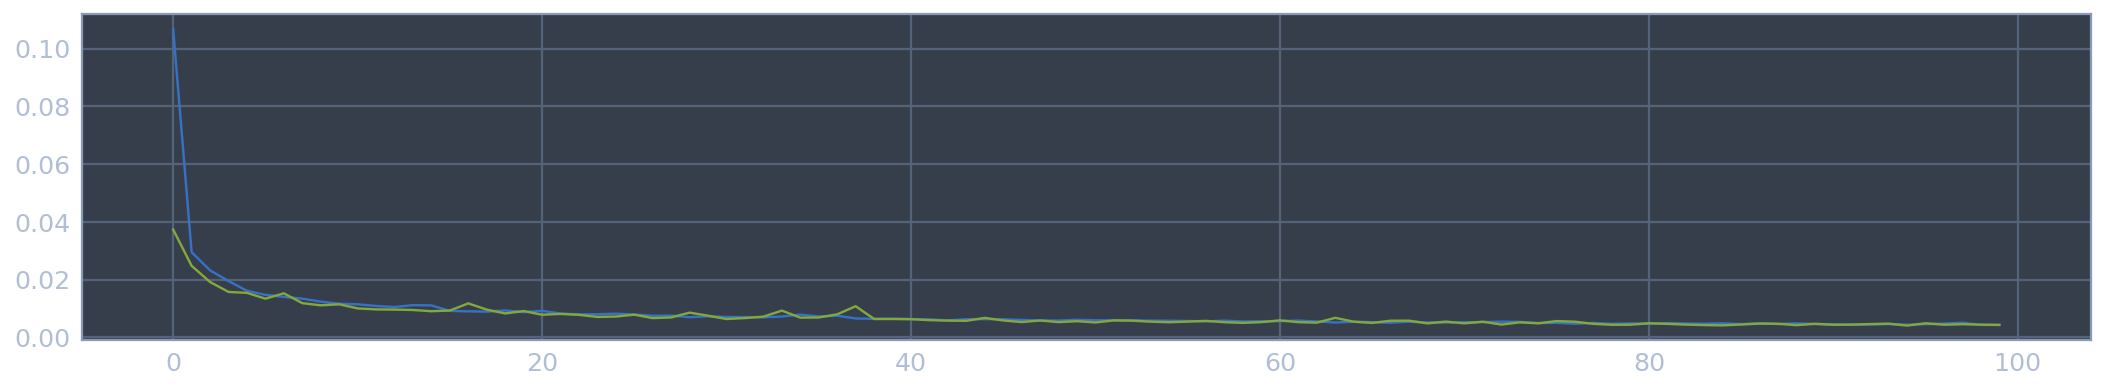

time: 550 ms


In [42]:
print( h.history[ 'loss' ][ -1 ], h.history[ 'val_loss' ][ -1 ] )
pd.Series( h.history[ 'loss' ] ).plot();
pd.Series( h.history[ 'val_loss' ] ).plot();

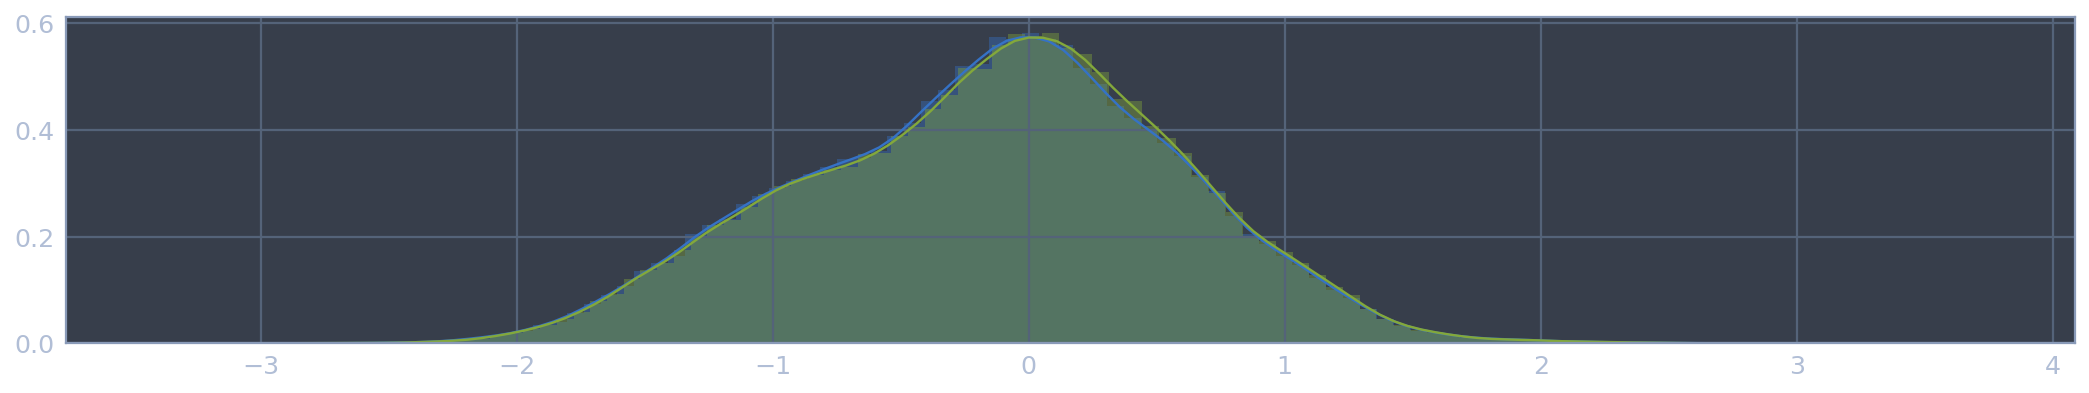

time: 925 ms


In [43]:
sns.distplot( train_y[ :, 0 ], bins=100 );
sns.distplot( p, bins=100 );

In [44]:
scipy.stats.ks_2samp( train_y[ :, 0 ], p.reshape( -1 ) )

Ks_2sampResult(statistic=0.012986404125644557, pvalue=2.2676597989375279e-11)

time: 54.7 ms


# single concatenated model for all dimensions (with standardization)

In [45]:
m_in = keras.layers.Input( shape=( x_dim, ) )
m_outs = [ keras.layers.Dense( 1, kernel_initializer='glorot_normal' )( keras.layers.Activation( 'tanh' )( keras.layers.BatchNormalization()( keras.layers.Dense( 64, kernel_initializer='glorot_normal' )( m_in ) ) ) ) for _ in range( y_dim ) ]
m_out = keras.layers.Concatenate()( m_outs )
m = keras.models.Model( inputs=m_in, outputs=m_out )
m.compile( optimizer='adam', loss='mse' )
m.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 376)          0                                            
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 64)           24128       input_6[0][0]                    
__________________________________________________________________________________________________
dense_14 (Dense)                (None, 64)           24128       input_6[0][0]                    
__________________________________________________________________________________________________
dense_16 (Dense)                (None, 64)           24128       input_6[0][0]                    
__________________________________________________________________________________________________
dense_18 (

In [46]:
cbs = [ keras.callbacks.EarlyStopping( min_delta=0, patience=10 ) ]
h = m.fit( train_x2, train_y, batch_size=1024, epochs=100, verbose=0, callbacks=cbs, validation_data=( val_x2, val_y ) )
p = m.predict( train_x2, batch_size=1024 )

time: 20min 43s


0.005644338428 0.00686209967911


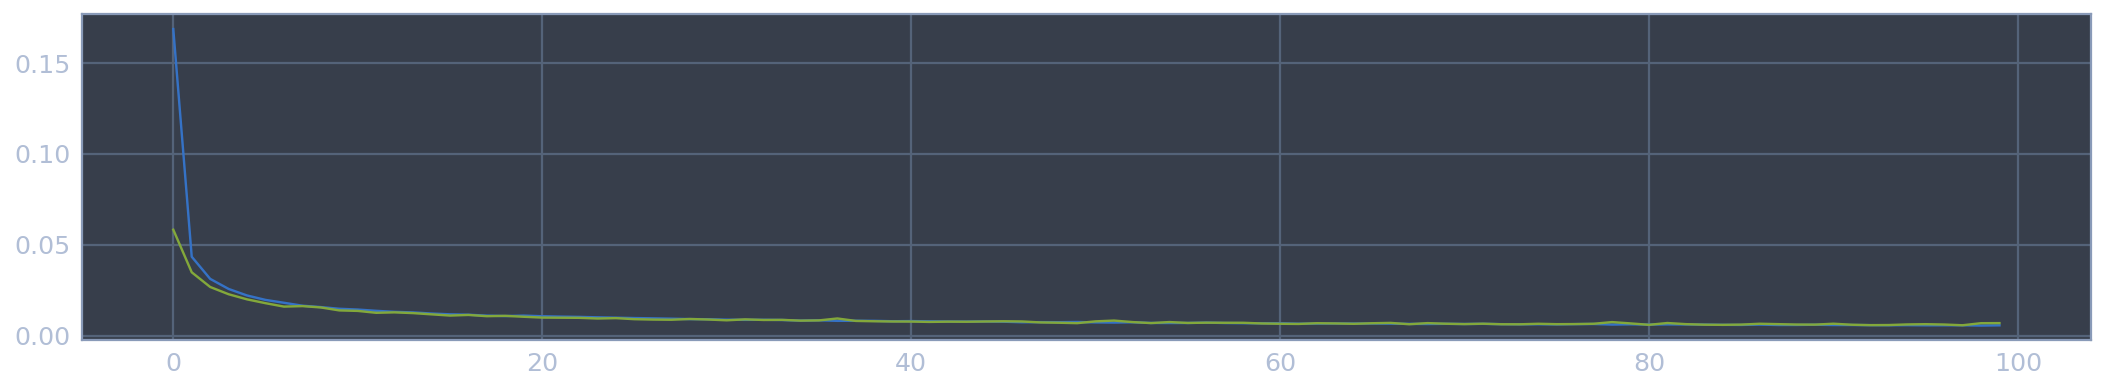

time: 445 ms


In [47]:
print( h.history[ 'loss' ][ -1 ], h.history[ 'val_loss' ][ -1 ] )
pd.Series( h.history[ 'loss' ] ).plot();
pd.Series( h.history[ 'val_loss' ] ).plot();

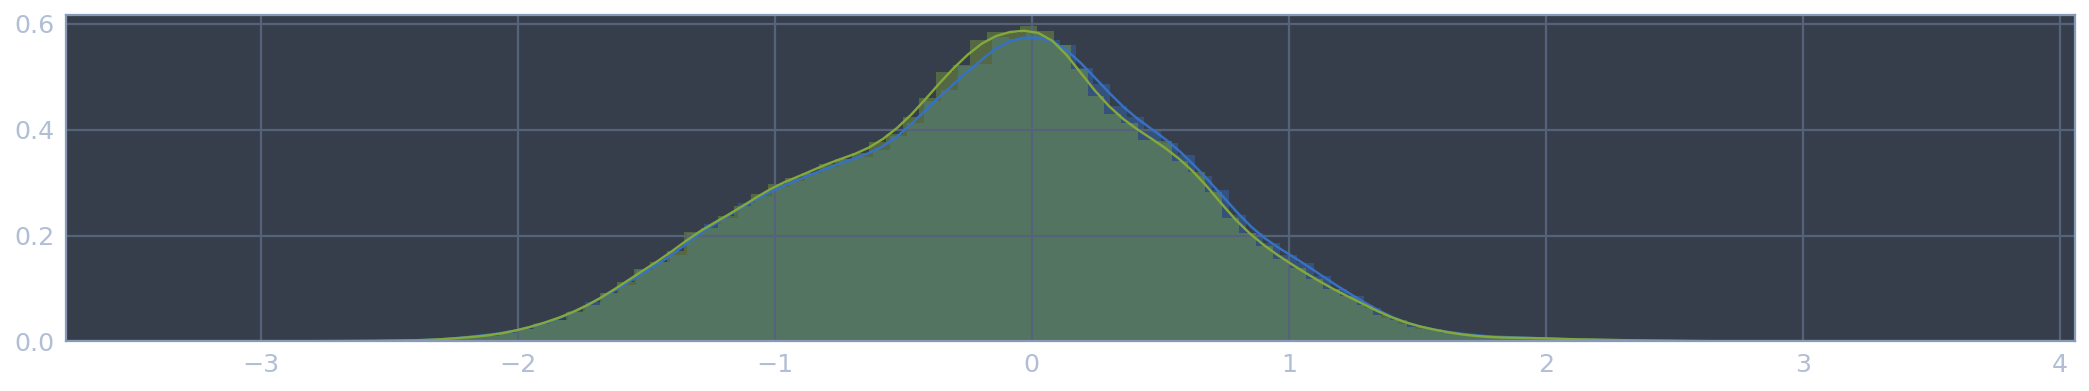

time: 856 ms


In [48]:
sns.distplot( train_y[ :, 0 ], bins=100 );
sns.distplot( p[ :, 0 ], bins=100 );

In [49]:
[ scipy.stats.ks_2samp( y[ :, i ], p[ :, i ] ) for i in range( y_dim ) ]

[Ks_2sampResult(statistic=0.019976706703825453, pvalue=5.0395280936450338e-30),
 Ks_2sampResult(statistic=0.022057247802833579, pvalue=1.6445146928536607e-36),
 Ks_2sampResult(statistic=0.0050382425805278741, pvalue=0.026201412054098178),
 Ks_2sampResult(statistic=0.010336534282737952, pvalue=2.3795426365295743e-08),
 Ks_2sampResult(statistic=0.0025356449258329139, pvalue=0.64240478264722078),
 Ks_2sampResult(statistic=0.0097474799456163108, pvalue=1.7945624935460261e-07),
 Ks_2sampResult(statistic=0.019271163783063039, pvalue=5.7044688249876114e-28),
 Ks_2sampResult(statistic=0.013246070704598933, pvalue=1.938252477054524e-13),
 Ks_2sampResult(statistic=0.012998614407766673, pvalue=5.8761943591024141e-13),
 Ks_2sampResult(statistic=0.0098786841281452431, pvalue=1.1560327798645067e-07),
 Ks_2sampResult(statistic=0.010875071078859377, pvalue=3.3825243029883882e-09),
 Ks_2sampResult(statistic=0.016994943987837074, pvalue=7.5659021542514097e-22),
 Ks_2sampResult(statistic=0.01819122773100

time: 1.02 s


In [50]:
t = [ scipy.stats.ks_2samp( y[ :, i ], p[ :, i ] ).statistic for i in range( y_dim ) ]
np.mean( t ), np.var( t )

(0.012904276887891425, 2.5594188517018001e-05)

time: 897 ms


# single concatenated model for all dimensions (with standardization)

In [51]:
m_in = keras.layers.Input( shape=( x_dim, ) )
m_outs = [ keras.layers.Dense( 1, kernel_initializer='glorot_normal' )( keras.layers.Activation( 'tanh' )( keras.layers.BatchNormalization()( keras.layers.Dense( 1024, kernel_initializer='glorot_normal' )( m_in ) ) ) ) for _ in range( y_dim ) ]
m_out = keras.layers.Concatenate()( m_outs )
m = keras.models.Model( inputs=m_in, outputs=m_out )
m.compile( optimizer='adam', loss='mse' )
m.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 376)          0                                            
__________________________________________________________________________________________________
dense_46 (Dense)                (None, 1024)         386048      input_7[0][0]                    
__________________________________________________________________________________________________
dense_48 (Dense)                (None, 1024)         386048      input_7[0][0]                    
__________________________________________________________________________________________________
dense_50 (Dense)                (None, 1024)         386048      input_7[0][0]                    
__________________________________________________________________________________________________
dense_52 (

In [52]:
cbs = [ keras.callbacks.EarlyStopping( min_delta=0, patience=10 ) ]
h = m.fit( train_x2, train_y, batch_size=1024, epochs=100, verbose=0, callbacks=cbs, validation_data=( val_x2, val_y ) )
p = m.predict( train_x2, batch_size=1024 )

time: 2h 4min 42s


0.00912565186153 0.0113833815739


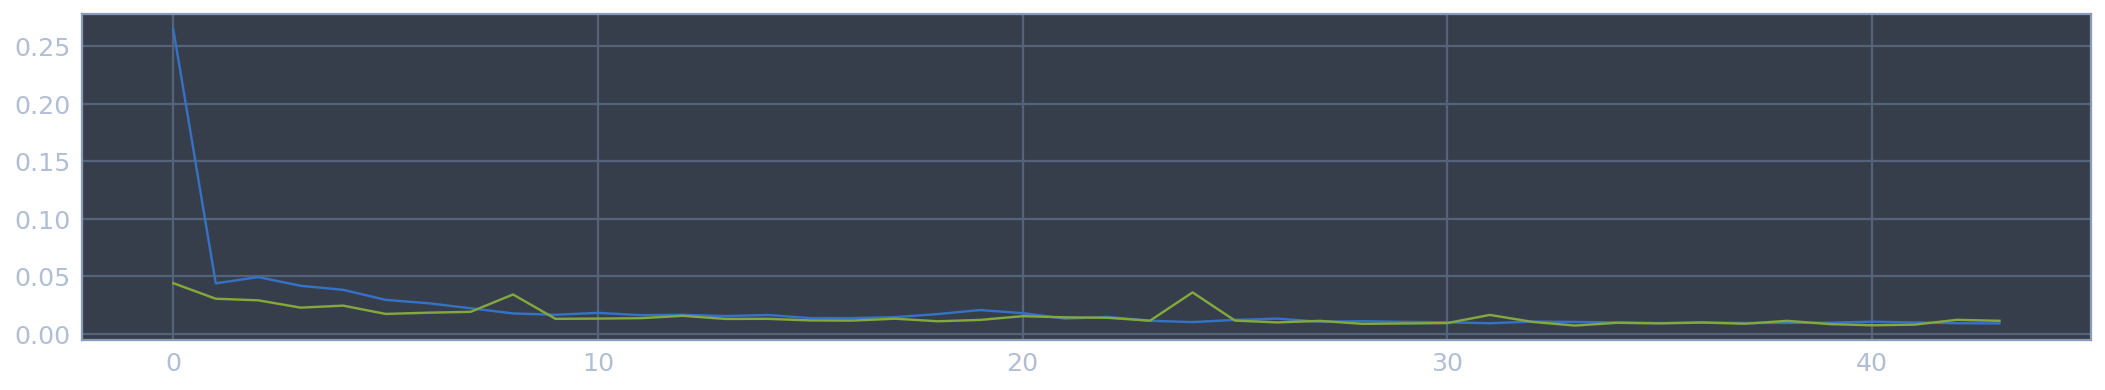

time: 1.11 s


In [53]:
print( h.history[ 'loss' ][ -1 ], h.history[ 'val_loss' ][ -1 ] )
pd.Series( h.history[ 'loss' ] ).plot();
pd.Series( h.history[ 'val_loss' ] ).plot();

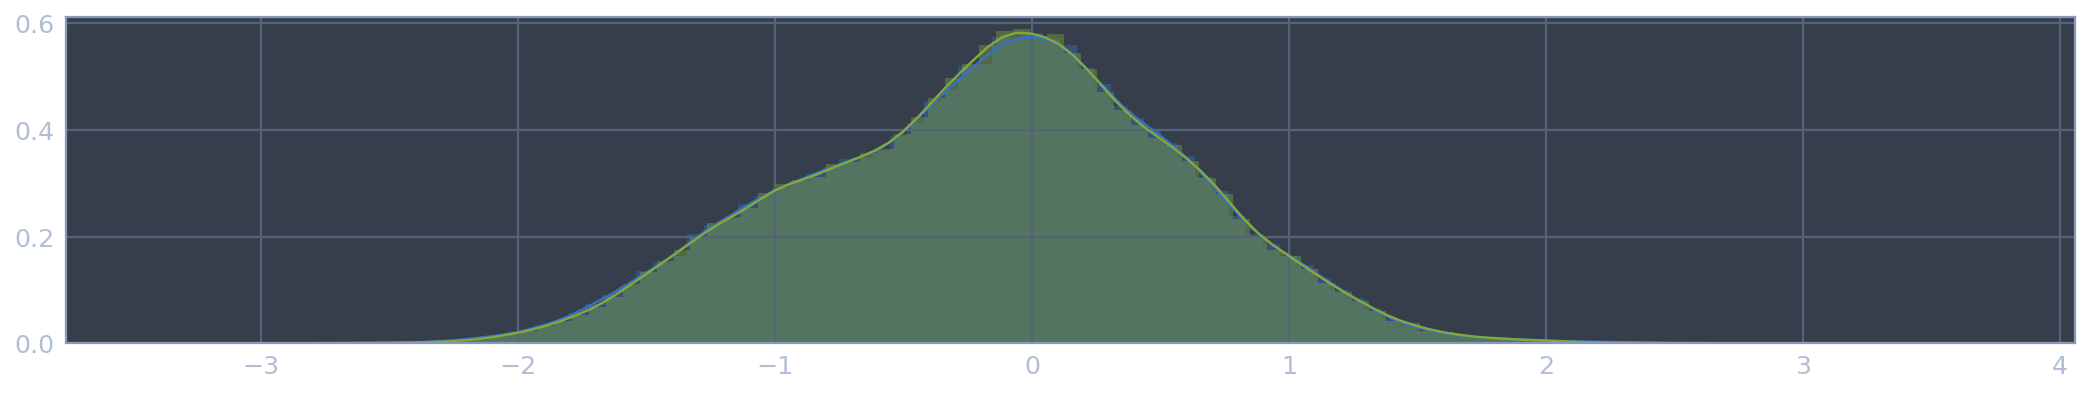

time: 2.48 s


In [54]:
sns.distplot( train_y[ :, 0 ], bins=100 );
sns.distplot( p[ :, 0 ], bins=100 );

In [55]:
[ scipy.stats.ks_2samp( y[ :, i ], p[ :, i ] ) for i in range( y_dim ) ]

[Ks_2sampResult(statistic=0.0050464232959571143, pvalue=0.025834840781921452),
 Ks_2sampResult(statistic=0.024967380292943098, pvalue=1.1644740866501542e-46),
 Ks_2sampResult(statistic=0.004833348342189181, pvalue=0.037011787180393919),
 Ks_2sampResult(statistic=0.023499746959137813, pvalue=2.1975351554931245e-41),
 Ks_2sampResult(statistic=0.018850880865152964, pvalue=8.8015354031537811e-27),
 Ks_2sampResult(statistic=0.006912266283908175, pvalue=0.0005718276852198339),
 Ks_2sampResult(statistic=0.044452038847793668, pvalue=5.5432986501689768e-147),
 Ks_2sampResult(statistic=0.023722156042935871, pvalue=3.6556716892027671e-42),
 Ks_2sampResult(statistic=0.012719935108723046, pvalue=1.9984078738884895e-12),
 Ks_2sampResult(statistic=0.014592423393045797, pvalue=3.217468654778822e-16),
 Ks_2sampResult(statistic=0.023299645421714033, pvalue=1.0876860957823807e-40),
 Ks_2sampResult(statistic=0.040144315012823117, pvalue=5.9205659854420984e-120),
 Ks_2sampResult(statistic=0.014760535093420

time: 1.49 s


In [56]:
t = [ scipy.stats.ks_2samp( y[ :, i ], p[ :, i ] ).statistic for i in range( y_dim ) ]
np.mean( t ), np.var( t )

(0.021646376363756579, 0.00014799423554188207)

time: 1.15 s
